<a href="https://colab.research.google.com/github/MelMacLondon/ML/blob/main/TEDAI_TiRex_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Travelers Wanted: Forecasting the Unseen with TiRex

**Workshop Description:**

In a world of ever-growing AI models, a small but mighty time series foundation model from Austria is challenging the rules. TiRex, an xLSTM-based model developed by [NXAI](https://www.nx-ai.com), has shown competitive zero-shot forecasting results alongside models from Amazon, Google, Salesforce, and Alibaba — despite using far fewer parameters and less computational power.

In this TEDAI workshop, we will take you on a fast-paced journey into the heart of time series innovation. We'll crack open the architecture of xLSTM, unpack why TiRex works so well in zero-shot settings, and then jump straight into live forecasting. Bring your own data and put TiRex to the test on your laptop. Expect a hands-on session where predictions take center stage.

Whether you're a data scientist, ML engineer, or just a curious tinkerer wondering if foundation models have a future beyond language, this workshop is your invitation to forecast the future — literally. Laptops required. Some familiarity with data formats (e.g., CSV) is helpful, but no deep learning experience necessary.


## Introduction to xLSTM and TiRex for Time Series Forecasting

**xLSTM (Extended Long Short-Term Memory)** is a powerful new architecture for sequence modeling, building upon the success of traditional LSTMs. It introduces key innovations that enhance its ability to capture long-range dependencies and complex patterns in data, making it particularly well-suited for tasks like time series forecasting.

**TiRex** leverages the power of xLSTM to provide a state-of-the-art framework for time series forecasting. By utilizing the advanced sequence modeling capabilities of xLSTM, TiRex can generate accurate forecasts across various time horizons and data characteristics — without being trained on task-specific data. This capability is referred to *zero-shot* forecasting.

**Potential Applications:**

TiRex can be applied to a wide range of real-world time series forecasting problems, including (but not limited to):

*   **Demand Forecasting:** Estimating future product demand for inventory management and supply chain optimization.
*   **Energy Forecasting:** Predicting electricity consumption or renewable energy generation.
*   **Traffic Forecasting:** Anticipating traffic flow for urban planning and navigation systems.
*   **Environmental Forecasting:** Modeling climate patterns or predicting pollution levels.


## TiRex Forecasting - Theory

Forecasting with TiRex is straightforward and typically involves two main steps:

1.  **Loading the Model:** You need to load a pre-trained TiRex model using the `load_model()` function. This function fetches the model architecture and weights, preparing it for making predictions.
2.  **Generating Forecasts:** Once the model is loaded, you use the `.forecast()` method of the model object, providing your historical time series data (context) and the desired prediction length.

TiRex is designed to be flexible and supports various input and output formats, which are demonstrated in the following sections of this notebook.

### Input Options

The `.forecast()` method in TiRex is designed to handle different input formats for your time series data (context):

* **Torch tensor (1D or 2D):**

  You can pass your time series data as a PyTorch tensor. If you have multiple time series, you can provide them as a 2D tensor where each row represents a time series.

* **List of Torch tensors (List of 1D):**

  If you have multiple time series of potentially different lengths, you can provide them as a list of 1D PyTorch tensors. TiRex will automatically handle padding to ensure consistent input dimensions for batch processing.

* **NumPy array (1D or 2D):**

  Similar to Torch tensors, you can also use NumPy arrays as input. This is convenient if your data is initially loaded using libraries like pandas or NumPy.

* **List of NumPy arrays (List of 1D):**
  
  For multiple time series of varying lengths in NumPy format, a list of 1D NumPy arrays is supported. Padding will be applied as needed.

* **GluonTS Dataset:**

  If you are working within the GluonTS ecosystem, TiRex can directly accept a GluonTS Dataset object, simplifying integration with existing GluonTS workflows. This requires the optional `gluonts` dependency to be installed.

As demonstrated in the code examples, you can see the resulting shape of the predictions for each input type, highlighting how TiRex processes these different formats.

### Output Options

TiRex does not only predict a single forecast but instead provides quantile predictions. These quantiles can be used to estimate the uncertainty of the model.

TiRex provides flexibility in the format of the generated forecasts through the `output_type` parameter in the `.forecast()` method:

* **"torch" (Default):**

  The forecast quantiles and means are returned as 3D and 2D PyTorch tensors. This is the default behavior and is useful if you plan to perform further operations using PyTorch.

* **"numpy":**

  The forecast quantiles and means are returned as a 3D and 2D NumPy arrays. This is convenient for integration with libraries like pandas or for general-purpose numerical processing.

* **"gluonts":**

  The forecasts are returned as a list of GluonTS `QuantileForecast` objects. This is ideal if you are working within the GluonTS framework and want to leverage its functionality for evaluation, visualization, or further processing. This option also requires the optional `gluonts` dependency.

Additionally, for handling large datasets or managing memory, the `yield_per_batch=True` option can be used with the `.forecast()` method. When set to `True`, the function becomes an iterable, yielding forecasts batch by batch instead of returning all predictions at once. This allows you to process forecasts in chunks, which can be more efficient for large-scale forecasting tasks.

## TiRex Forecasting - Practice

In order to utilise TiRex, we need to install the package via `pip`.


In [ ]:
!pip install 'tirex-ts[notebooks]' -q

In [ ]:
# standard imports
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# TiRex specific imports
from tirex import load_model

In [ ]:
# load a TiRex model (automatically fetching the weights from HuggingFace)
model = load_model("NX-AI/TiRex")

In [ ]:
# plotting function which also accepts future values and forecasts.
def plot_fc(ctx, real_future_values=None, forecasts=None):
    # figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # plot context
    original_x = range(len(ctx))
    ax.plot(original_x, ctx, label="Ground Truth Context", color="#4a90d9")

    # plot future values if given
    if real_future_values is not None:
        future_x = range(len(ctx), len(ctx) + len(real_future_values))
        ax.plot(future_x, real_future_values, label="Ground Truth Future", color="#4a90d9", linestyle="--")
        # horizontal mark
        ax.axvline(len(ctx), color="#4a90d9", linestyle=":")

    # plot forecast if given
    if forecasts is not None:
        # forecasts are expected to be a 2D tensor with quantiles as rows
        median_forecast = forecasts[:, 4].numpy()
        lower_bound = forecasts[:, 0].numpy()
        upper_bound = forecasts[:, 8].numpy()

        # plot median and quantiles
        forecast_x = range(len(ctx), len(ctx) + len(median_forecast))
        ax.plot(forecast_x, median_forecast, label="Forecast (Median)", color="#d94e4e", linestyle="-")
        ax.fill_between(forecast_x, lower_bound, upper_bound, color="#d94e4e", alpha=0.1, label="Forecast 10% - 90% Quantiles")

    # set bounds and add legend and plot everything
    plt.xlim(left=0)
    plt.legend()
    plt.grid(True)
    plt.show()

### Toy example: sine wave

torch.Size([1, 20, 9]) torch.Size([1, 20])


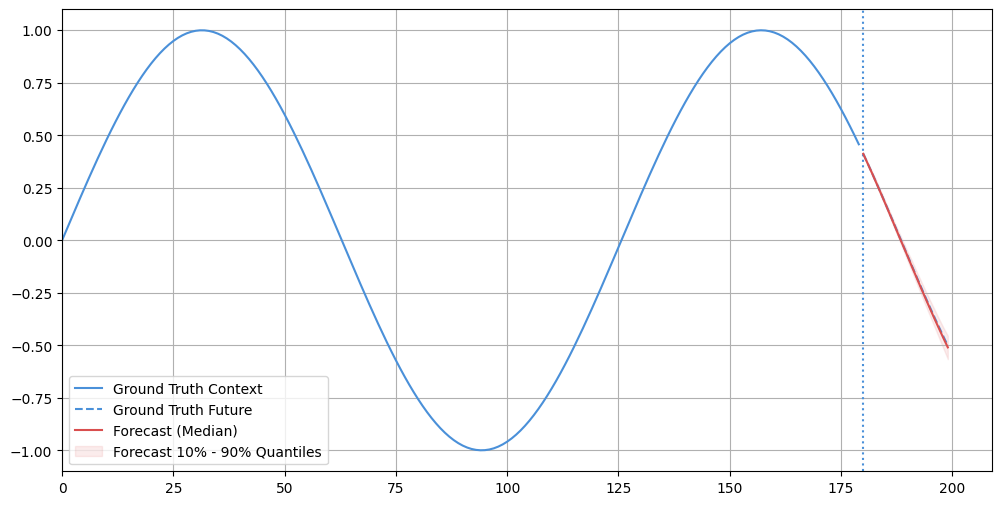

In [ ]:
# generate a simple sine wave
sin = np.sin(np.arange(0, 10, 0.05))

# split sine wave into context (to be learnt from) and future values
prediction_length = 20
sin_context, sin_future = np.split(sin, [-prediction_length])

# make a forecast based on the context
# model.forecast() returns quantiles and a mean of the prediction
forecast_quantiles, forecast_mean = model.forecast(sin_context, prediction_length=prediction_length, resample_strategy=None)
# shape of forecasts
print(forecast_quantiles.shape, forecast_mean.shape)
# we need to remove (squeeze) the batch dimension from the returned tensors to plot them
plot_fc(sin_context, sin_future, forecast_quantiles.squeeze())

## Hands-on session 1: forecasting with sample data

Run following code cells below load some example data and generate forecasts.

Experiment with the `prediction_length` parameter to see its effect.


In [ ]:
# load example data and split into context (to be learnt from) and future values
data_base_url = "https://raw.githubusercontent.com/NX-AI/tirex/refs/heads/main/tests/data/"

# short horizon example: air passengers per month
ctx_s, future_s = np.split(pd.read_csv(f"{data_base_url}/air_passengers.csv").values.reshape(-1), [-12])

# long horizon example: spatio-temporal speed information of the Seattle freeway system
ctx_l, future_l = np.split(pd.read_csv(f"{data_base_url}/loop_seattle_5T.csv").values.reshape(-1), [-512])

### Short Horizon - Example

Short series (number of air passengers per month):


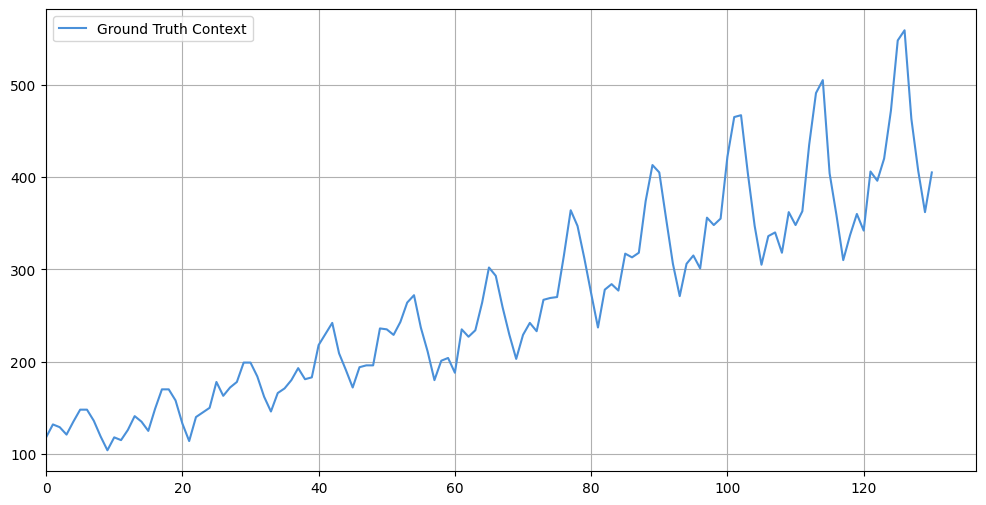

In [ ]:
# plot time series
print("Short series (number of air passengers per month):")
plot_fc(ctx_s)

Short series (number of air passengers per month):


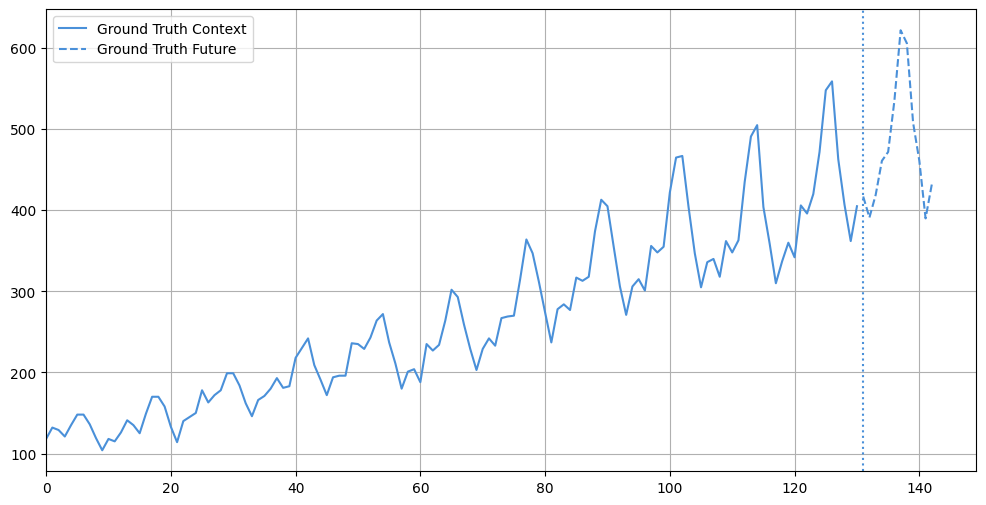

In [ ]:
# plot time series with future values
print("Short series (number of air passengers per month):")
plot_fc(ctx_s, future_s)

Short series (number of air passengers per month): prediction_length=12


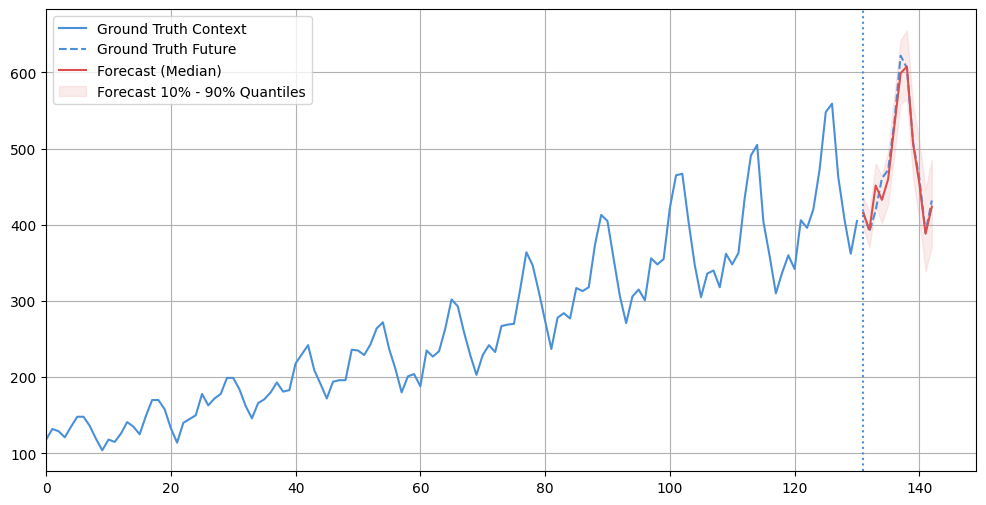

In [ ]:
# make some predictions, starting with original prediction length
prediction_length = 12
quantiles_s_orig, mean_s_orig = model.forecast(ctx_s, prediction_length=prediction_length)

print(f"Short series (number of air passengers per month): {prediction_length=}")
plot_fc(ctx_s, future_s, quantiles_s_orig[0])

Short series (number of air passengers per month): prediction_length=24


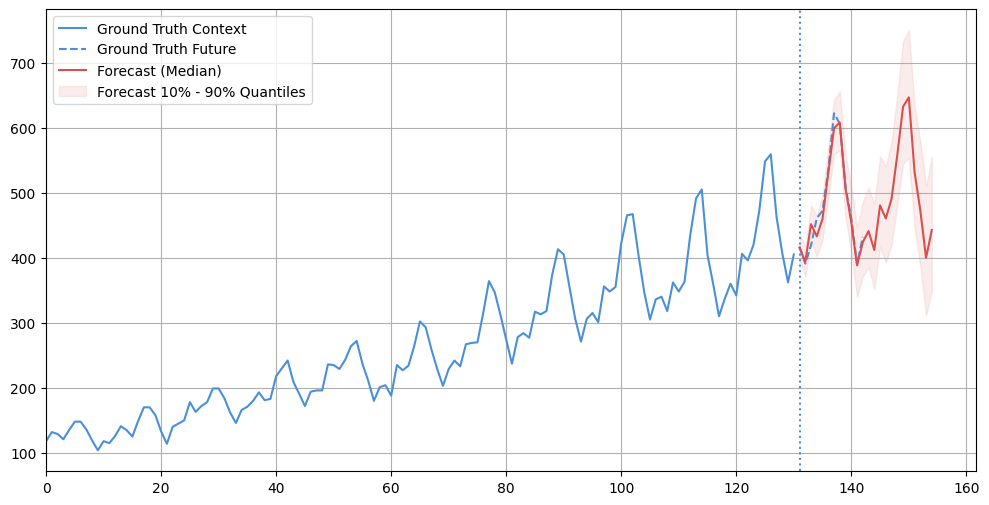

In [ ]:
# extend prediction length
prediction_length = 24
quantiles_s_orig, mean_s_orig = model.forecast(ctx_s, prediction_length=prediction_length)

print(f"Short series (number of air passengers per month): {prediction_length=}")
plot_fc(ctx_s, future_s, quantiles_s_orig[0])

Short series (number of air passengers per month): prediction_length=100


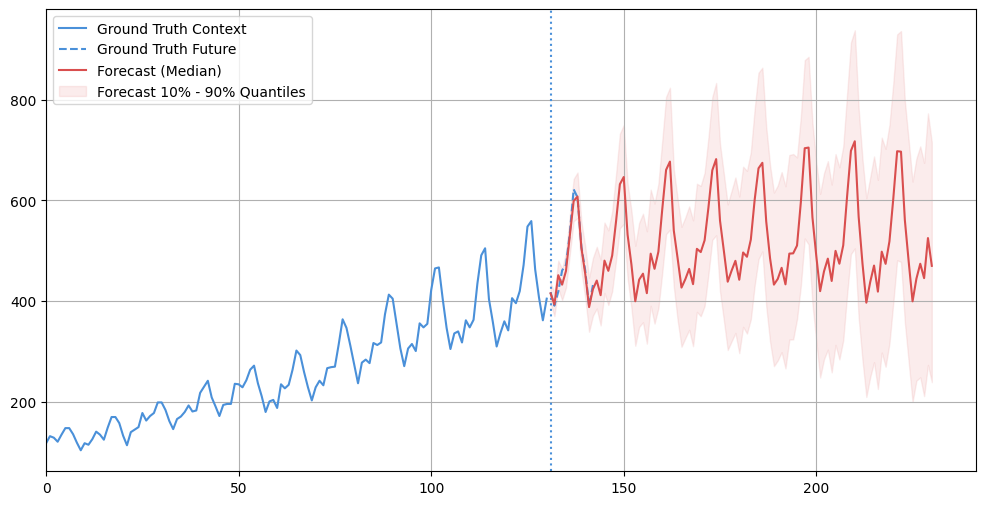

In [ ]:
# further extend prediction length
# (longer prediction lengths lead to higher uncertainty)
prediction_length = 100
quantiles_s_orig, mean_s_orig = model.forecast(ctx_s, prediction_length=prediction_length)

print(f"Short series (number of air passengers per month): {prediction_length=}")
plot_fc(ctx_s, future_s, quantiles_s_orig[0])

Long series (spatio-temporal speed information of the Seattle freeway system): prediction_length=512


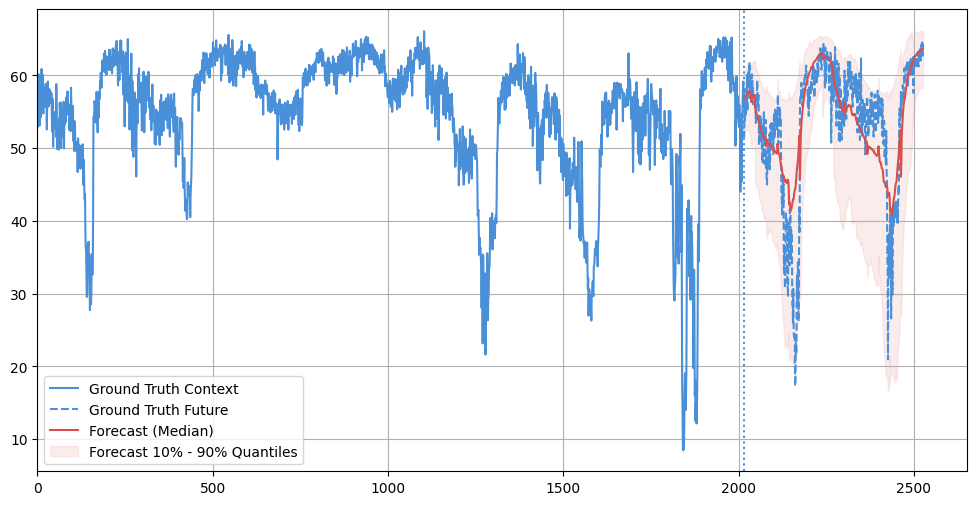

In [ ]:
# original forecast length
prediction_length = 512
quantiles_l_orig, mean_l_orig = model.forecast(ctx_l, prediction_length=prediction_length)

print(f"Long series (spatio-temporal speed information of the Seattle freeway system): {prediction_length=}")
plot_fc(ctx_l, future_l, quantiles_l_orig[0])

Long series (spatio-temporal speed information of the Seattle freeway system): prediction_length=768


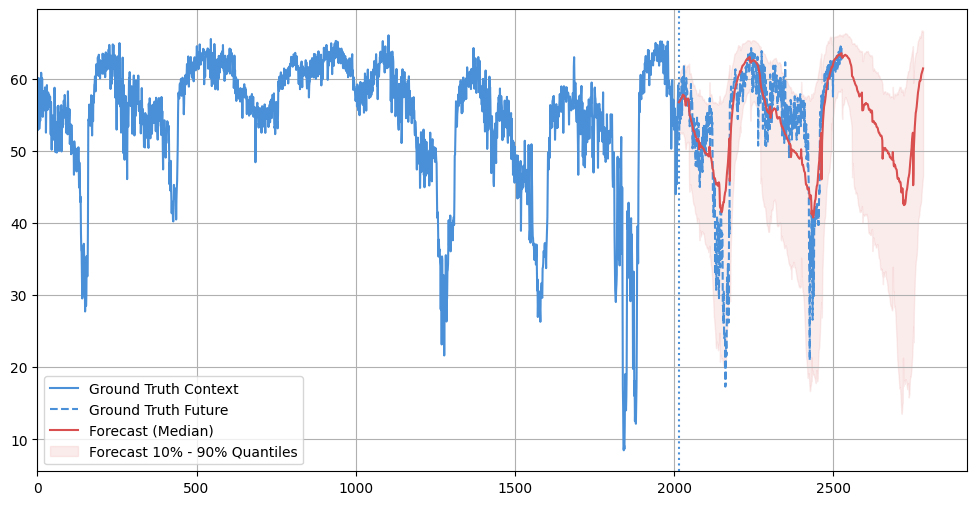

In [ ]:
# extend forecast length
prediction_length = 768
quantiles_l_orig, mean_l_orig = model.forecast(ctx_l, prediction_length=prediction_length)

print(f"Long series (spatio-temporal speed information of the Seattle freeway system): {prediction_length=}")
plot_fc(ctx_l, future_l, quantiles_l_orig[0])

In [ ]:
# extend forecast length even further
prediction_length = 1024
quantiles_l_orig, mean_l_orig = model.forecast(ctx_l, prediction_length=prediction_length)

print(f"Long series (spatio-temporal speed information of the Seattle freeway system): {prediction_length=}")
plot_fc(ctx_l, future_l, quantiles_l_orig[0])

## 📏 Forecast Evaluation Metrics

- **Mean Absolute Percentage Error (MAPE)**
  
  Calculates the average absolute error as a percentage of the actual values. This makes it a relative measure, independent of the scale of the data.

  *Interpretation:* MAPE expresses the average error in percentage terms. A MAPE of 10% means that, on average, the forecast is off by 10% of the actual value. This can be very useful for comparing forecast accuracy across time series with different scales (e.g., forecasting sales for a high-volume product vs. a low-volume product).

- **Mean Absolute Error (MAE)**

  Represents the average absolute difference between the forecasts and the actual values. It tells you, on average, how far off your predictions are from the real outcomes, ignoring the direction of the error (whether you predicted too high or too low).

  *Interpretation:* The MAE is expressed in the same units as your original time series data. For example, if you are forecasting daily sales in dollars, an MAE of 50 means your forecasts are off by $50, on average.

- **Mean Squared Error (MSE)**

  Calculates the average of the squared differences between forecasts and actual values. By squaring the errors, it gives significantly more weight to larger errors than smaller ones.

  *Interpretation:* The MSE is measured in the square of the original data units (e.g., dollars squared if forecasting sales). This makes direct interpretation less intuitive compared to MAE. A lower MSE indicates a better fit, but the magnitude itself is harder to relate directly to the scale of the data.

- **Root Mean Squared Error (RMSE)**

  Is simply the square root of the MSE. Taking the square root addresses the primary interpretation issue of MSE by returning the error metric to the original data units.

  *Interpretation:* Like MAE, the RMSE is expressed in the same units as the original time series data. An RMSE of 55 for daily sales forecasts means the typical magnitude of the error is around 55. Because it′s derived from squared errors, the RMSE will always be greater than or equal to the MAE. The difference between RMSE and MAE can indicate the variance in the individual errors a larger difference suggests the presence of some larger errors that disproportionately influence RMSE.

In [ ]:
def mape(x, ref):
  return np.mean(np.abs((np.array(ref) - np.array(x)) / np.array(ref))) * 100

def mae(x, ref):
  return np.mean(np.abs(np.array(ref) - np.array(x)))

def mse(x, ref):
  return np.mean((np.array(ref) - np.array(x)) ** 2)

def rmse(mse):
  return np.sqrt(mse)


mean_s = mean_s_orig[:, :future_s.shape[0]]
mean_l = mean_l_orig[:, :future_l.shape[0]]

print(f"MAPE [%] short: {mape(mean_s, future_s):6.2f} long: {mape(mean_l, future_l):6.2f}")
print(f"MAE      short: {mae(mean_s, future_s):6.2f} long: {mae(mean_l, future_l):6.2f}")
print(f"MSE      short: {mse(mean_s, future_s):6.2f} long: {mse(mean_l, future_l):6.2f}")
print(f"RMSE     short: {rmse(mse(mean_s, future_s)):6.2f} long: {rmse(mse(mean_l, future_l)):6.2f}")

## Hands-on Session 2: Forecasting with Your Own Data

Now it's your turn to apply TiRex forecasting to your own time series data!

Follow these steps:

1.  **Upload your data:** If you haven't already, upload your time series data file(s) using the file icon on the left sidebar, as explained in the "Uploading Your Own Data" section.
2.  **Load your data:** In the code cell below, write code to load your data into a NumPy array or a PyTorch tensor. Remember the data format guidelines: 1D for a single series, 2D or list of 1D for multiple series. You can use `np.genfromtxt` or `pd.read_csv` for CSV files.
3.  **Prepare your data (if necessary):** Ensure your data is in the correct numerical format. If you loaded from a CSV, you might need to select the relevant column(s) containing the time series values.
4.  **Adapt the forecasting code:** Use your loaded data as the `context` argument in the `model.forecast()` method.
5.  **Choose prediction length:** Select an appropriate `prediction_length` for your forecast based on your data and needs.
6.  **Generate and visualize forecasts:** Run the code to generate the forecasts. If you have corresponding ground truth data for the forecast period, you can include it as the second argument in `plot_fc()` to compare your forecast with the actual future values.

Modify the code cell below to work with *your* data file name and desired settings.


### Uploading Your Own Data

To use your own time series data with TiRex, you first need to upload it to your Colab environment. You can do this by:

1.  Clicking the **folder icon** on the left sidebar.
2.  Clicking the **upload icon** (arrow pointing up) and selecting your data file(s) from your local machine.

Your files will be uploaded to the current working directory, which is `/content/` as set in the previous cell.

### Data Preparation Guidelines

Your time series data should be in a format that can be easily loaded into Python. Common formats include CSV files.

When loading your data, make sure it is represented as:

-   A **one-dimensional NumPy array** for a single time series.
-   A **two-dimensional NumPy array** where each row is a time series (for multiple time series).
-   A **one-dimensional PyTorch tensor** for a single time series.
-   A **list of one-dimensional PyTorch tensors** for multiple time series.

For CSV files, you can often load them using `np.genfromtxt` or `pd.read_csv` and then convert to the required NumPy array or PyTorch tensor format.

In [ ]:
# 1. Specify the path to your data file.
# Make sure your file is uploaded to the Colab environment (e.g., using the file icon on the left).
# Replace 'your_data.csv' with the actual name of your file.
your_data_path = '/content/your_data.csv'

# 2. Load your data.
# Example using numpy.genfromtxt for a simple CSV with one column:
try:
    your_data = np.genfromtxt(your_data_path)
    print(f"Loaded data from {your_data_path} with shape: {your_data.shape}")

    # If your data is in a different format (e.g., multiple columns, includes headers),
    # you might need to use pandas:
    # import pandas as pd
    # df = pd.read_csv(your_data_path)
    # Select the column(s) containing your time series values:
    # your_data = df['your_column_name'].values # for a single series
    # your_data = df[['col1', 'col2']].values # for multiple series

    # Ensure your data is a NumPy array or PyTorch tensor as required by TiRex
    # If using pandas, the .values attribute gives a NumPy array.
    # To convert to torch tensor: your_data = torch.tensor(your_data, dtype=torch.float32)


    # 3. Define the prediction length.
    # Choose a length appropriate for your forecasting needs.
    your_prediction_length = 30 # Example: forecast 30 steps into the future

    # 4. Generate forecasts using your data.
    # The 'model' object was loaded in a previous cell.
    # If your_data is 1D, model.forecast expects it to be treated as a single series.
    # If your_data is 2D, each row is treated as a series.
    your_quantiles, your_mean = model.forecast(context=your_data, prediction_length=your_prediction_length)

    # 5. Visualize the results.
    # plot_fc expects the context (your_data), future values (if available),
    # and the quantiles (your_quantiles[0] for the first series).
    # If you don't have ground truth for the future, just provide the first two arguments.

    # Example with no ground truth for the future:
    print("\nGenerating plot without ground truth for future:")
    plot_fc(your_data, None, your_quantiles[0])

    # Example if you have ground truth for the future (replace your_future_data):
    # Assuming you split your loaded data into context and future similar to the examples
    # your_context, your_future_data = np.split(your_data, [-your_prediction_length])
    # print("\nGenerating plot with ground truth for future:")
    # plot_fc(your_context, your_future_data, your_quantiles[0])

except FileNotFoundError:
    print(f"Error: Data file not found at {your_data_path}.")
    print("Please upload your data file to the Colab environment.")
except Exception as e:
    print(f"An error occurred during data processing or forecasting: {e}")

## Interpreting and Visualizing Forecast Results

The `model.forecast()` method returns two main components: `quantiles` and `mean`.

*   **Mean:** This is the point forecast, representing the model's single best estimate for the future values of the time series.
*   **Quantiles:** These represent a set of prediction intervals. Each quantile value corresponds to a specific probability level. For example, the 0.1 (10th percentile) and 0.9 (90th percentile) quantiles define an 80% prediction interval, meaning there is an estimated 80% probability that the true future value will fall between these two values. TiRex provides multiple quantiles (e.g., 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99), allowing for a detailed understanding of the uncertainty associated with the forecast.

The `plot_fc` function is a helpful utility to visualize these results:

*   It shows the **historical context** (the data the model saw) in blue.
*   The **true future values** are plotted as a dashed line, allowing for a visual comparison of the forecast accuracy.
*   The **forecasted mean** is typically shown as a solid line in the forecast horizon.
*   The **prediction intervals** derived from the quantiles are visualized as shaded regions. Wider shaded areas indicate higher uncertainty in the forecast for that time step. The different shades might represent different confidence levels (e.g., a darker shade for the 80% interval and a lighter shade for the 95% interval, depending on the plotting implementation).


### Using GluonTS Output Format

For users who are already working within the GluonTS ecosystem, TiRex provides a convenient way to obtain forecasts in the GluonTS `QuantileForecast` format. This is achieved by setting the `output_type` parameter to "gluonts" in the `model.forecast()` or `model.forecast_gluon()` methods.

The `QuantileForecast` object is a standard format in GluonTS and offers several advantages for further processing:

*   **Standardization:** It provides a consistent structure for accessing forecast values, including quantiles, mean, start time, and item ID.
*   **Integration:** It seamlessly integrates with other GluonTS functionalities, such as evaluation metrics, visualization tools, and ensemble methods.
*   **Rich Information:** It encapsulates not just the point forecast but also the probabilistic forecast information (quantiles), which is crucial for decision-making under uncertainty.

As demonstrated in the "Output Options" section of this notebook, you can see examples of how to obtain forecasts in the GluonTS `QuantileForecast` format and even visualize them using GluonTS's built-in plotting capabilities.

In [ ]:
ls /content/

## Open Floor for Questions and Discussion

We've now explored xLSTM and TiRex, loaded example data, generated forecasts, and hopefully, you've had the chance to experiment with your own datasets.

This is a great time to open the floor for questions and discussion. We encourage you to share your experiences and insights!

Here are some topics to get us started:

*   What are your thoughts on the xLSTM architecture and its potential for time series forecasting?
*   How does TiRex simplify the forecasting process compared to other methods you might have used?
*   What challenges did you encounter when working with your own data?
*   How do you interpret the quantile forecasts and prediction intervals for your specific use case?
*   Were the forecast results surprising or in line with your expectations?
*   Are there any specific applications of TiRex that you find particularly interesting?

Let's discuss! Feel free to ask anything about xLSTM, TiRex, the forecasting process, or your results.


## Workshop Summary

In this workshop, we explored **xLSTM**, a powerful new architecture for sequence modeling, and **TiRex**, a state-of-the-art library that leverages xLSTM for time series forecasting.

We covered the following key points:

*   **Introduction to xLSTM and TiRex:** Understanding the capabilities of xLSTM and how TiRex provides a streamlined interface for applying it to forecasting tasks.
*   **TiRex Forecasting Process:** Learning the basic steps involved in generating forecasts, from loading a pre-trained model to making predictions.
*   **Input and Output Options:** Exploring the flexibility of TiRex in handling various data formats for both input (Torch tensors, NumPy arrays, lists, GluonTS Dataset) and output (Torch tensors, NumPy arrays, GluonTS QuantileForecast).
*   **Hands-on Forecasting:** Gaining practical experience by generating forecasts using both provided example datasets and participants' own time series data.
*   **Result Interpretation and Visualization:** Understanding how to interpret the mean and quantile forecasts and using the `plot_fc` utility for visualization.

**Where to Learn More:**

To continue your journey with TiRex and xLSTM, here are some valuable resources:

*   **TiRex GitHub Repository:** [https://github.com/NX-AI/tirex](https://github.com/NX-AI/tirex) - The official source code, documentation, and examples. This is the best place to find the latest updates and contribute.
*   **TiRex Research Paper:** [https://arxiv.org/abs/2505.23719](https://arxiv.org/abs/2505.23719) - For a deeper understanding of TiRex and its technical details, refer to the original research paper.
*   **xLSTM Research Paper:** [https://arxiv.org/abs/2405.04517](https://arxiv.org/abs/2405.04517) - For a deeper understanding of the xLSTM architecture and its technical details, refer to the original research paper.
*   **Hugging Face Model Hub:** [https://huggingface.co/NX-AI/TiRex](https://huggingface.co/NX-AI/TiRex) - Where the pre-trained TiRex model is hosted.

**Using TiRex in Your Projects:**

Here are some ideas for how you can integrate and further explore TiRex in your own time series projects:

*   **Experiment with Different Datasets:** Apply TiRex to other time series datasets relevant to your work or interests (e.g., sensor data, sales data, website traffic).
*   **Integrate into Workflows:** Incorporate TiRex forecasting into your existing data pipelines or applications.
*   **Compare with Other Models:** Evaluate TiRex's performance against other time series forecasting methods you might be using.
*   **Contribute to TiRex:** If you're a developer, consider contributing to the open-source TiRex project on GitHub.

We hope this workshop has provided you with a solid foundation for using TiRex for your time series forecasting needs!